# Import necessary libraries

In [1]:
# from eval_on_test import read_data
#https://huggingface.co/docs/transformers/tasks/token_classification

In [2]:
import pandas as pd
import gzip
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, pipeline,  AutoModelForTokenClassification
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from functools import partial



device = "cuda" if torch.cuda.is_available() else "cpu"
device

2024-03-06 20:26:45.536344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 20:26:45.536413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 20:26:45.542510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 20:26:45.557502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 20:26:47.244975: W tensorflow/compiler/tf2

'cuda'

In [3]:
id2label = {0: 'O',1: 'I-ORG', 2: 'I-PER', 3: 'I-LOC', 4: 'B-ORG', 5: 'B-PER', 6: 'B-LOC'}
label2id = {v:i for i,v in id2label.items()}
label2id

{'O': 0,
 'I-ORG': 1,
 'I-PER': 2,
 'I-LOC': 3,
 'B-ORG': 4,
 'B-PER': 5,
 'B-LOC': 6}

# Load Data

In [141]:
def read_and_combine_datasets(fpaths):
    """
    Read and combine datasets from given file paths.

    Args:
        fpaths (list of str): List of file paths.

    Returns:
        combined_df (DataFrame): Combined dataset.
    """
    combined_data = []
    for fpath in fpaths:
        with gzip.open(fpath, 'rt', encoding='utf-8') as f:
            data = [line.strip().split('\t') for line in f.readlines() if line.strip()]
            combined_data.extend(data)

    df  = pd.DataFrame(combined_data, columns=["token", "label"])
    df['sentence_start'] = (df['token'].str.endswith('.')).shift(1, fill_value=True).cumsum()
    sentences_df = df.groupby('sentence_start').agg({'token': list, 'label': list}).reset_index(drop=True)
    # Rename columns to match the desired output
    sentences_df.columns = ['sentence', 'label']
    # sentences_df = sentences_df[sentences_df['sentence'].apply(len) >= 2]

    return sentences_df

def stratified_split_train_set(train_df, test_size=0.2, random_state=42):
    """
    Perform a stratified split on the training set.

    Args:
        train_df (DataFrame): Training dataset.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    # Stratify by labels to maintain distribution
    strats= list(pd.cut(train_df["sentence"].apply(len), bins=[0, 5, 10, 15, 20, 25, 30, 55, 80, 100, 200],
                                                                    labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-55', '50-80', '80-100', '100-200']).values)
    return train_test_split(train_df["sentence"], train_df["label"], test_size=test_size, random_state=random_state, stratify=strats)


def analyze_dataset(dataset, labels):
    num_examples = len(dataset)
    num_tokens = sum(len(text) for text in dataset)
    named_entities = dict(Counter(ent for label in labels for ent in label).most_common())
    total_unique_words = len(set(word for sentence in dataset for word in sentence))
    return "Len: "+ str(num_examples),  "Tokens: "+str(num_tokens), "Unique: "+str(total_unique_words), "Entities: "+ str(named_entities)


def combine_and_split_datasets(train_langs=["en", "it", "af", "sw", "de"], data_dir="/fp/projects01/ec30/IN5550/obligatories/2/data"):
    """
    Combine, split datasets based on specified languages, and prepare training and validation sets.

    Args:
        train_langs (list of str): Languages for training data.
        val_langs (list of str): Languages for validation data.
        data_dir (str): Directory where the datasets are stored.

    Returns:
        training_set, X_train, X_test, y_train, y_test, validation_set: Prepared datasets.
    """
    # Combine training datasets
    train_paths = [f"{data_dir}/train-{lang}.tsv.gz" for lang in train_langs]
    training_set = read_and_combine_datasets(train_paths)

    # Stratified split on training set
    _X_train, _X_val, _y_train, _y_val = stratified_split_train_set(training_set)
    print("Train Language(s):", train_langs)
    print("Train Set:", analyze_dataset(_X_train,_y_train ))
    print("Val Set:",  analyze_dataset(_X_val, _y_val))

    return list(_X_train), list(_X_val) , list(_y_train), list(_y_val)

def getTestDatasets(val_langs=["en"], data_dir="/fp/projects01/ec30/IN5550/obligatories/2/data"):
    all_set ={}
    for lang in val_langs:
        val_set = read_and_combine_datasets([f"{data_dir}/dev-{lang}.tsv.gz"])
        _X_test,_y_test  = list(val_set["sentence"]), list(val_set["label"])
        print(f"Test Set({lang}):",  analyze_dataset(_X_test,_y_test))
        all_set[lang] = _X_test,_y_test
    return all_set

In [142]:

class NERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label2id):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = tokenizer.model_max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        word_labels = self.labels[idx]

        tokenized_inputs = self.tokenizer(text, is_split_into_words=True, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt", add_special_tokens=True)

        input_ids = tokenized_inputs['input_ids'].squeeze()
        attention_mask = tokenized_inputs['attention_mask'].squeeze()

        labels = []
        word_ids = tokenized_inputs.word_ids(batch_index=0)  # Get word_ids for the current sequence
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Special tokens
                labels.append(-100)  # PyTorch's convention to ignore these labels during loss calculation
            elif word_idx != previous_word_idx:  # New word
                labels.append(self.label2id[word_labels[word_idx]])
            else:  # Subtoken of the previous word
                labels.append(self.label2id[word_labels[word_idx]])
            previous_word_idx = word_idx

        label_tensor = torch.LongTensor(labels)

        # Ensure label_tensor is padded/truncated to the correct length
        # This might not be necessary if your tokenizer already ensures correct padding
        # but is here for safety
        # padded_label_tensor = torch.full((self.max_length,), fill_value=-100, dtype=torch.long)
        # padded_label_tensor[:len(labels)] = label_tensor[:self.max_length]

        return input_ids, attention_mask, label_tensor

In [173]:
def collate_fn(batch, pad_token_id):
    input_ids, attention_masks, labels = zip(*batch)

    # Pad sequences so they match the longest sequence in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Assuming labels are already tensors. If not, you might need to convert or pad them here
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100) # Use -100 for ignored index in CrossEntropyLoss

    return input_ids_padded.to(device), attention_masks_padded.to(device), labels_padded.to(device)

In [180]:
from seqeval.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

def validate(model, data_loader, evaluate=False,lang="en"):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, atn_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=atn_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            prediction = outputs.logits.argmax(dim=2).cpu().numpy()
            
            cropped_predictions = [pred[1:len(mask) - 1 - mask.flip(dims=[0]).argmax()] for pred, mask in zip(prediction, atn_mask)]
            cropped_true_labels = [true[1:len(mask) - 1 - mask.flip(dims=[0]).argmax()] for true, mask in zip(labels.cpu().numpy(), atn_mask)]

            predictions.extend(cropped_predictions)
            true_labels.extend(cropped_true_labels)

    avg_loss = total_loss / len(data_loader)

    # Convert predictions and true labels to tag sequences
    id2label = {v: k for k, v in label2id.items()}
    pred_tags = [[id2label[tag_id] for tag_id in seq] for seq in predictions]
    true_tags = [[id2label[tag_id] if tag_id in id2label else '-100' for tag_id in seq] for seq in true_labels]
    f1_score_ = f1_score(true_tags, pred_tags)
    if evaluate:
        print(f"LANG [{lang}]: F1-score (Token-level) : {f1_score_:.3f}")
        print(f'Test Loss: {test_loss} \n Test Evaluation (strict IOB2):')
        print(classification_report(true_tags, pred_tags, zero_division=0, mode='strict', scheme=IOB2, digits=3))
    return avg_loss, true_tags, pred_tags, f1_score_


def plot_loss(train_losses, val_losses, f1_scores):
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='.', label='Val. F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.show()


def train(model, train_loader, val_loader, epochs=3, lr=5e-5, early_stopping_patience=3, finetune=False):
    model.requires_grad_(finetune)
    model.classifier.requires_grad_(True)
    model.train()
    print("Trainable parameters: ", format(sum(p.numel() for p in model.parameters() if p.requires_grad), ","))

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    train_losses = []
    val_losses = []
    val_f1s =[]
    
    best_val_loss, best_epoch = float('inf'), 0
    epochs_without_improvement = 0
    best_model_state_dict = None

    for epoch in range(epochs):
        total_train_loss = 0

        # Training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
        for batch in progress_bar:
            model.train()
            input_ids, atn_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=atn_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': loss.item()})
        train_losses.append(total_train_loss / len(train_loader))

        # Validation
        val_loss, true_tags, pred_tags, f1_score = validate(model, val_loader)
        val_f1s.append(f1_score)
        val_losses.append(val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train_loss : {loss.item():.4f}, val_loss: {val_loss:.4f}, val_f1: {f1_score:.4f}')
        scheduler.step(val_loss)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss, best_epoch = val_loss, epoch
            epochs_without_improvement = 0
            best_model_state_dict = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch + 1} as validation loss has not decreased for {early_stopping_patience} epochs since epoch-{best_epoch}.')
                break

    # Load the best model state
    model.load_state_dict(best_model_state_dict)

    plot_loss(train_losses, val_losses,val_f1s )
    return model

In [181]:
# model_path = "/fp/projects01/ec30/models/xlm-roberta-base/"
# # "/fp/projects01/ec30/models/bert-base-multilingual-cased/"

# tokenizer = AutoTokenizer.from_pretrained(model_path, model_max_length=256)
# model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(label2id)).to(device)

# X_train, X_val, y_train, y_val = combine_and_split_datasets(["en"])
# # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased", model_max_length=128)
# # model = AutoModelForTokenClassification.from_pretrained("google-bert/bert-base-multilingual-cased", num_labels=len(label2id)).to(device)
# train_loader = DataLoader(NERDataset(X_train, y_train, tokenizer, label2id), batch_size=32, shuffle=True, collate_fn=partial(collate_fn, pad_token_id =tokenizer.pad_token_id))
# val_loader = DataLoader(NERDataset(X_val, y_val, tokenizer, label2id), batch_size=32, shuffle=False, collate_fn=partial(collate_fn, pad_token_id =tokenizer.pad_token_id))
# _model = train(model, train_loader, val_loader, epochs=10, lr=1e-5, finetune=True)

# for lang, data in getTestDatasets(["en", "de"]).items():
#     X_test, y_test = data
#     test_loader = DataLoader(NERDataset(X_test, y_test, tokenizer, label2id), batch_size=32, shuffle=False, collate_fn=partial(collate_fn, pad_token_id =tokenizer.pad_token_id))
#     test_loss, true_tags, pred_tags, _ = validate(model, test_loader, evaluate=True, lang=lang)

In [182]:
from torch.utils.data import DataLoader
from functools import partial

def train_test(train_langs, val_langs, model_path, epochs=50, lr=1e-5, bs=32, finetune=True, model_max_length=256):
    tokenizer = AutoTokenizer.from_pretrained(model_path, model_max_length=model_max_length)
    model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(label2id)).to(device)

    X_train, X_val, y_train, y_val = combine_and_split_datasets(train_langs)
    train_loader = DataLoader(NERDataset(X_train, y_train, tokenizer, label2id), batch_size=bs, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
    val_loader = DataLoader(NERDataset(X_val, y_val, tokenizer, label2id), batch_size=bs, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
    model = train(model, train_loader, val_loader, epochs=epochs, lr=lr, finetune=finetune)

    for lang, data in getTestDatasets(val_langs=val_langs).items():
        X_test, y_test = data
        test_loader = DataLoader(NERDataset(X_test, y_test, tokenizer, label2id), batch_size=bs, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=tokenizer.pad_token_id))
        test_loss, true_tags, pred_tags, _ = validate(model, test_loader, evaluate=True, lang=lang)

# train_test(["en"], ["en", "de"], model_path = "/fp/projects01/ec30/models/xlm-roberta-base/")

# Part 1: Finetuning Multilingual Transformers on English)

## 1A: Different Language Models

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/xlm-roberta-base/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 4556', 'Tokens: 128281', 'Unique: 28743', "Entities: {'O': 65043, 'I-ORG': 18457, 'I-PER': 11776, 'I-LOC': 10576, 'B-LOC': 7536, 'B-ORG': 7536, 'B-PER': 7357}")
Val Set: ('Len: 1140', 'Tokens: 32113', 'Unique: 10288', "Entities: {'O': 16319, 'I-ORG': 4769, 'I-PER': 2922, 'I-LOC': 2601, 'B-ORG': 1886, 'B-LOC': 1809, 'B-PER': 1807}")
Trainable parameters:  277,458,439


Epoch 1/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.6396, val_loss: 0.5165, val_f1: 0.6292


Epoch 2/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.3508, val_loss: 0.4048, val_f1: 0.7182


Epoch 3/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.4397, val_loss: 0.3747, val_f1: 0.7386


Epoch 4/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.2552, val_loss: 0.3557, val_f1: 0.7473


Epoch 5/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.2595, val_loss: 0.3474, val_f1: 0.7620


Epoch 6/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.2660, val_loss: 0.3511, val_f1: 0.7612


Epoch 7/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1451, val_loss: 0.3422, val_f1: 0.7690


Epoch 8/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 8/50, train_loss : 0.1956, val_loss: 0.3518, val_f1: 0.7693


Epoch 9/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 9/50, train_loss : 0.2576, val_loss: 0.3552, val_f1: 0.7741


Epoch 10/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 10/50, train_loss : 0.1890, val_loss: 0.3657, val_f1: 0.7742
Early stopping at epoch 10 as validation loss has not decreased for 3 epochs since epoch-6.


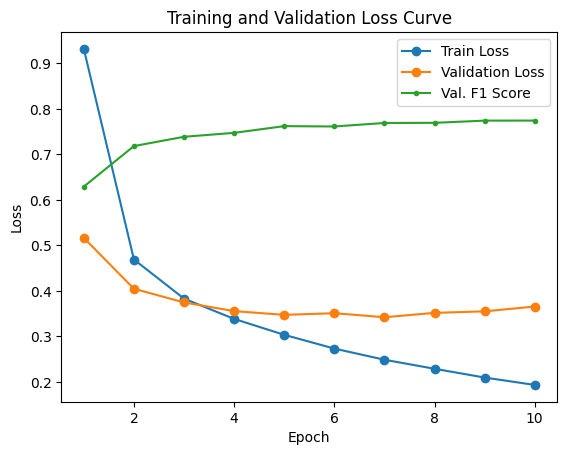

Test Set(en): ('Len: 2891', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
LANG [en]: F1-score (Token-level) : 0.775
Test Loss: 0.41733370153676896 
 Test Evaluation (strict IOB2):
              precision    recall  f1-score   support

         LOC      0.804     0.855     0.829      9660
         ORG      0.719     0.646     0.681      7929
         PER      0.832     0.854     0.843      7016

   micro avg      0.788     0.788     0.788     24605
   macro avg      0.785     0.785     0.784     24605
weighted avg      0.785     0.788     0.785     24605



In [183]:
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/xlm-roberta-base/")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 4556', 'Tokens: 128281', 'Unique: 28743', "Entities: {'O': 65043, 'I-ORG': 18457, 'I-PER': 11776, 'I-LOC': 10576, 'B-LOC': 7536, 'B-ORG': 7536, 'B-PER': 7357}")
Val Set: ('Len: 1140', 'Tokens: 32113', 'Unique: 10288', "Entities: {'O': 16319, 'I-ORG': 4769, 'I-PER': 2922, 'I-LOC': 2601, 'B-ORG': 1886, 'B-LOC': 1809, 'B-PER': 1807}")
Trainable parameters:  177,268,231


Epoch 1/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 1/50, train_loss : 0.5051, val_loss: 0.4403, val_f1: 0.6539


Epoch 2/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 2/50, train_loss : 0.2921, val_loss: 0.3618, val_f1: 0.7321


Epoch 3/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 3/50, train_loss : 0.3053, val_loss: 0.3363, val_f1: 0.7543


Epoch 4/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 4/50, train_loss : 0.3613, val_loss: 0.3328, val_f1: 0.7664


Epoch 5/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 5/50, train_loss : 0.3684, val_loss: 0.3262, val_f1: 0.7727


Epoch 6/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 6/50, train_loss : 0.2056, val_loss: 0.3381, val_f1: 0.7791


Epoch 7/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 7/50, train_loss : 0.1852, val_loss: 0.3325, val_f1: 0.7811


Epoch 8/50:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 8/50, train_loss : 0.1234, val_loss: 0.3449, val_f1: 0.7796
Early stopping at epoch 8 as validation loss has not decreased for 3 epochs since epoch-4.


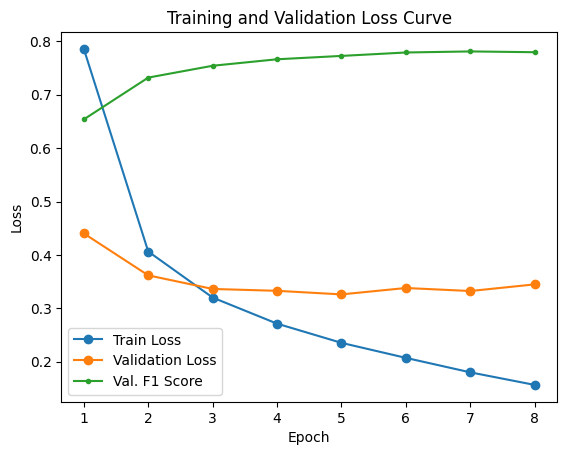

Test Set(en): ('Len: 2891', 'Tokens: 80536', 'Unique: 20222', "Entities: {'O': 40875, 'I-ORG': 11638, 'I-PER': 7520, 'I-LOC': 6357, 'B-LOC': 4834, 'B-ORG': 4677, 'B-PER': 4635}")
LANG [en]: F1-score (Token-level) : 0.786
Test Loss: 0.41733370153676896 
 Test Evaluation (strict IOB2):
              precision    recall  f1-score   support

         LOC      0.836     0.848     0.842      8740
         ORG      0.685     0.692     0.689      7200
         PER      0.870     0.853     0.861      6254

   micro avg      0.796     0.799     0.797     22194
   macro avg      0.797     0.798     0.797     22194
weighted avg      0.796     0.799     0.798     22194



In [184]:
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

In [ ]:
#TODO custom model

## 1B: Finetuning and freezing

In [ ]:
#finetune= False {train classifier only]
train_test(["en"], ["en"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/", finetune=False,  lr=1e-3)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/projects01/ec30/models/bert-base-multilingual-cased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Language(s): ['en']
Train Set: ('Len: 4556', 'Tokens: 128281', 'Unique: 28743', "Entities: {'O': 65043, 'I-ORG': 18457, 'I-PER': 11776, 'I-LOC': 10576, 'B-LOC': 7536, 'B-ORG': 7536, 'B-PER': 7357}")
Val Set: ('Len: 1140', 'Tokens: 32113', 'Unique: 10288', "Entities: {'O': 16319, 'I-ORG': 4769, 'I-PER': 2922, 'I-LOC': 2601, 'B-ORG': 1886, 'B-LOC': 1809, 'B-PER': 1807}")
Trainable parameters:  5,383


Epoch 1/50:   0%|          | 0/143 [00:00<?, ?it/s]

## 1C:  evaluate the finetuned models on the development set in each language (English, Italian, Afrikaans, Swahili, and German).

In [ ]:
train_test(["en"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

# Part 2: Finetuning Multilingual Transformers on Mixture of Languages 

In [ ]:
train_test(["en",  "it"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

In [ ]:
train_test(["en",  "de"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

In [ ]:
train_test(["en", "it", "de"],["en", "it", "af", "sw", "de"], model_path = "/fp/projects01/ec30/models/bert-base-multilingual-cased/")

# Part 3: A Surprise Language 